In [1]:
!pip install  matplotlib
!pip install  numpy
!pip install  seaborn
!pip install  gymnasium==0.27.0
!pip install gymnasium[toy_text]
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.1/879.1 KB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True,render_mode="rgb_array")

/usr/local/lib/python3.9/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  warnings.warn(message, DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  warnings.warn(message, DeprecationWarning)


### Ref
> https://gymnasium.farama.org/environments/toy_text/blackjack/

```python 
import gymnasium as gym
gym.make('Blackjack-v1', natural=False, sab=False)
```



`natural=False:` Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

`sab=False`: Whether to follow the exact rules outlined in the book by Sutton and Barto. If sab is True, the keyword argument `natural` will be ignored. If the player achieves a natural blackjack and the dealer does not, the player will win (i.e. get a reward of +1). The reverse rule does not apply. If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

### Reference 
[1] R. Sutton and A. Barto, “Reinforcement Learning: An Introduction” 2020. [Online]. Available: http://www.incompleteideas.net/book/RLbook2020.pdf

In [3]:
env = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Observing the environment

In [4]:
# reset the environment to get the first observation
done = False
observation,info = env.reset()

#observation = (16,9,False)

### Note that our observation is a tupleconsisting of 3 values:

1. The players current sum
2. Values of the dealers face-up card
3. Boolean whether the player holds ausable ace (it is usable if it counts as 11without busting)

---


## Executing an action

#### After receiving our first observation, we are only going to use the ``env.step(action)`` function to interact with the environment. This function takes an action as input and executes it in the environment.Because that action changes the state of the environment, it returnsfour useful variables to us. These are:<br><br>-  ``next_state``: This is the observation that the agent will receive after taking the action.<br><br>-  ``reward``: This is the reward that the agent will receive after taking the action.<br><br>-  ``terminated``: This is a boolean variable that indicates whether or not the environment has terminated.:<br><br>-  ``truncated``: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.:<br><br>-  ``info``: This is a dictionary that might contain additional information about the environment.

##### The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are self-explanatory, but the ``info`` variable requires some additional explanation. This variable contains a dictionary that might have some extra information about the environment, but in the Blackjack-v1 environment you can ignore it. For example in Atari environments the info dictionary has a ``ale.lives`` key that tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over.

In [5]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action = 1

#execute the action in out environment and receive info after taking the step
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

**if terminated=true we should stop the current episode and begin a new one using env.reset()**

---
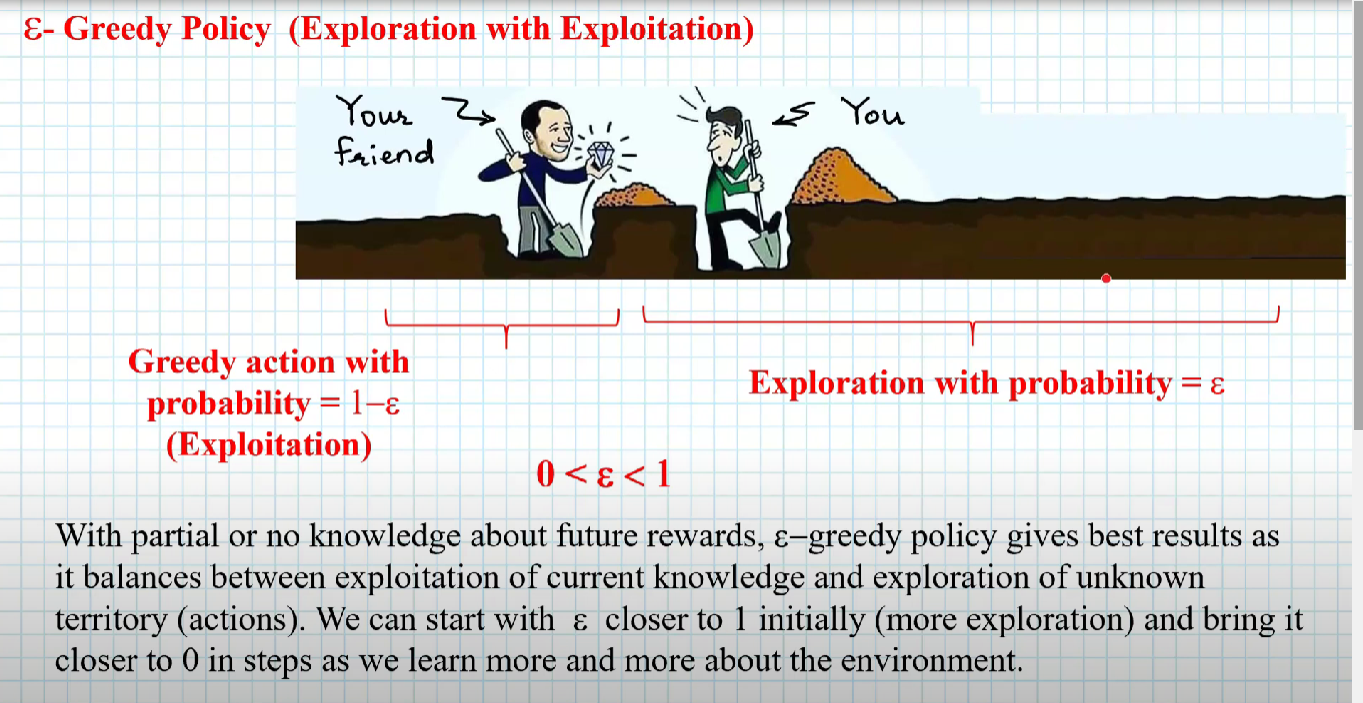

### Epsilon-greedy strategy to solve Blackjack

1. In this strategy, the agent takes an action that is either the best action based on the current policy (with a probability of 1-epsilon) or a random action (with a probability of epsilon). This approach balances the exploitation of the current best policy with exploration of new policies, which can lead to better rewards in the long run.

2. In the context of Blackjack, the epsilon-greedy strategy can be applied to determine whether the player should hit or stand. At each step of the game, the agent (i.e., the player) can choose to take the action that is either recommended by the current policy or a random action. The policy is learned over time by updating the action-value estimates of each state-action pair based on the rewards received during the game.

3. As the game is played repeatedly, the agent learns the optimal policy that maximizes the expected reward. Initially, the agent may explore by taking random actions to discover new strategies. However, as the game progresses, the agent will start to exploit the best-known policy, which should maximize the expected reward over time.

In [6]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

##### To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it’s Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.<br><br>Now we should be ready to build the training loop.


In [7]:
# hyperparameters
learning_rate = 0.01
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

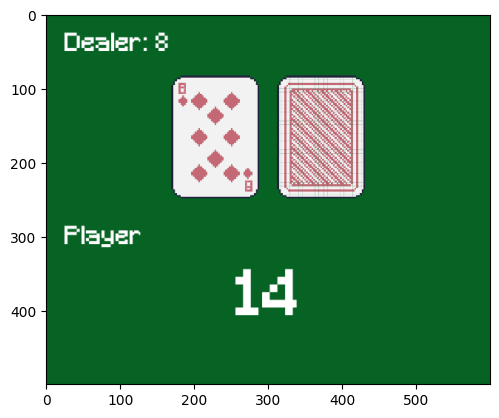

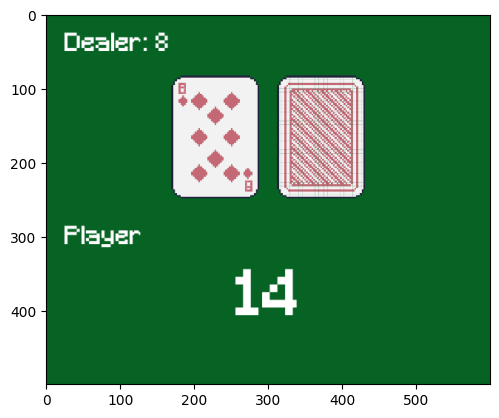

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


In [8]:
from IPython.display import clear_output
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        plt.imshow(frame)
        plt.show()
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

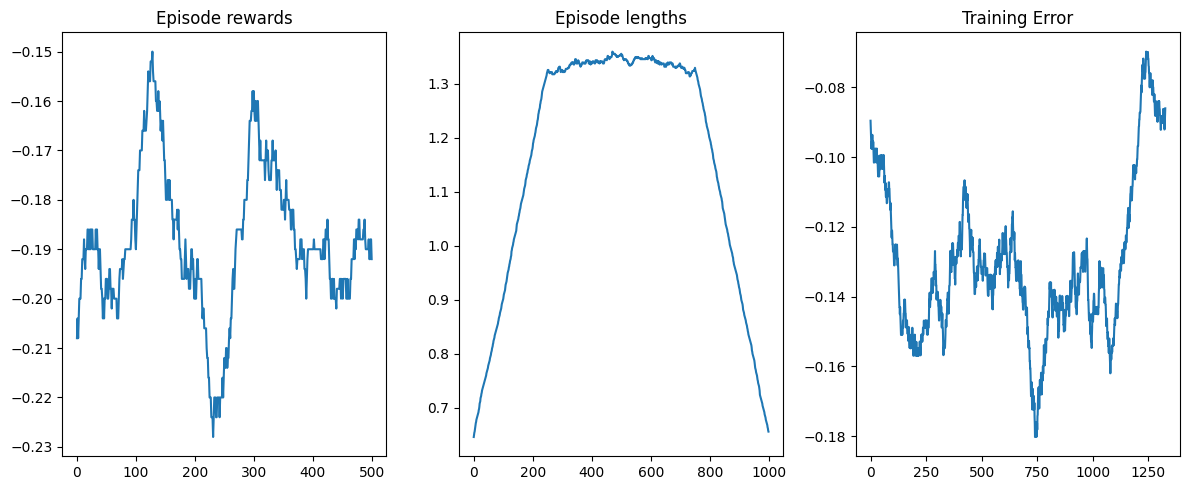

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()